# Reco-Modell erstellen

In [1]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import joblib

# Daten laden

In [2]:
bgdata = pd.read_pickle("../data/bg_data20240302.pkl")

In [3]:
bgdata.head()

,id,name,yearpublished,rank,bayesaverage,average,usersrated,abstracts_rank,cgs_rank,childrensgames_rank,...,boardgameintegration,boardgamegraphicdesigner,boardgameeditor,boardgamewriter,boardgamesculptor,boardgamesolodesigner,boardgamecompilation,boardgameinsertdesigner,boardgame,boardgameissuearticle
0,224517,Brass: Birmingham,2018,1,8.41720,8.60057,43723,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.38410,8.53050,52692,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,174430,Gloomhaven,2017,3,8.36528,8.59903,61211,NaN,NaN,NaN,...,"['Frosthaven', 'Gloomhaven: Jaws of the Lion',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,342942,Ark Nova,2021,4,8.33138,8.53762,40218,NaN,NaN,NaN,...,NaN,"['Steffen Bieker', 'Christof Tisch']","['Frank Heeren', 'Inga Keutmann', 'Bastian Win...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24165,8.60615,22955,NaN,NaN,NaN,...,NaN,Shaun Boyke,NaN,"['Adam Baker', 'Daniel Clark (I)']",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Doppelte Spalten "name" umbenennen:
colnames = bgdata.columns.tolist()
for y, new in zip([i for i, n in enumerate(bgdata.columns) if n == "name"], ["name", "other_names"]):
    colnames[y] = new
bgdata.columns = colnames

In [5]:
# weitere doppelte Spalten entfernen
bgdata = bgdata.loc[:,~bgdata.columns.duplicated()].copy()

In [6]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# Categories vercoden

In [7]:
bgdata["boardgamecategory"] = bgdata.boardgamecategory.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [8]:
categories = pd.get_dummies(bgdata.boardgamecategory.apply(pd.Series), prefix = "cat")

In [9]:
categories = categories.groupby(categories.columns, axis=1).max()

In [10]:
# Top-Kategorien ermitteln
topcat = categories.sum().sort_values(ascending=False).index.to_list()

In [11]:
# 20 Komponenten extrahieren
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(categories[topcat])
joblib.dump(pca, "../data/pca_cat.pkl")

['../data/pca_cat.pkl']

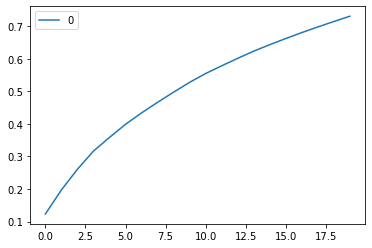

In [12]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [13]:
categories_pca = pd.DataFrame(pca.transform(categories), columns=["catp_" + str(x) for x in range(ncomp)])

In [14]:
bgdata = pd.concat([bgdata,categories_pca], axis=1)

# Mechanik

In [15]:
bgdata["boardgamemechanic"] = bgdata.boardgamemechanic.apply(lambda x: re.sub("['\[\]^\s+]", '', x).split(","))

In [16]:
mechanic = pd.get_dummies(bgdata.boardgamemechanic.apply(pd.Series), prefix = "mec")

In [17]:
mechanic = mechanic.groupby(mechanic.columns, axis=1).max()

In [18]:
# Top-Mechaniken ermitteln (später für Reco-Datensatz)
topmec = mechanic.sum().sort_values(ascending=False).index.to_list()

In [19]:
ncomp = 20
pca = PCA(n_components=ncomp)
pca.fit(mechanic[topmec])

PCA(n_components=20)

In [20]:
joblib.dump(pca, "../data/pca_mec.pkl")

['../data/pca_mec.pkl']

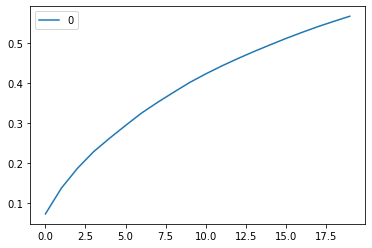

In [21]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().plot()

In [22]:
mechanic_pca = pd.DataFrame(pca.transform(mechanic), columns=["mecp_" + str(x) for x in range(ncomp)])

In [23]:
bgdata = pd.concat([bgdata,mechanic_pca], axis=1)

In [24]:
bgdata.columns

Index(['id', 'name', 'yearpublished', 'rank', 'bayesaverage', 'average',
       'usersrated', 'abstracts_rank', 'cgs_rank', 'childrensgames_rank',
       'familygames_rank', 'partygames_rank', 'strategygames_rank',
       'thematic_rank', 'wargames_rank', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'age', 'other_names',
       'description', 'thumbnail', 'image', 'boardgameaccessory',
       'boardgamepublisher', 'cardset', 'boardgamepodcastepisode',
       'boardgamehonor', 'boardgamecategory', 'videogamebg',
       'boardgamedesigner', 'boardgameartist', 'boardgameversion',
       'boardgamefamily', 'boardgamemechanic', 'boardgamesubdomain',
       'boardgameimplementation', 'suggested_numplayers',
       'language_dependence', 'suggested_playerage', 'rpgpodcastepisode',
       'boardgameexpansion', 'boardgamedeveloper', 'boardgameintegration',
       'boardgamegraphicdesigner', 'boardgameeditor', 'boardgamewriter',
       'boardgamesculptor', 'boa

# X_Train

In [25]:
allfeat = ['yearpublished', 'playingtime', 'age'] 

In [26]:
feat = allfeat + ["catp_" + str(x) for x in range(10)] + ["mecp_" + str(x) for x in range(10)]

In [27]:
x_train = bgdata[feat].copy()

In [36]:
#z-Transformation
scaler = StandardScaler()
for x in allfeat:
     x_train[x] = scaler.fit_transform(x_train[x].values.reshape(-1, 1))
     joblib.dump(scaler, f"../data/scaler_{x}.pkl")

In [29]:
x_train

,yearpublished,playingtime,age,catp_0,catp_1,catp_2,catp_3,catp_4,catp_5,catp_6,...,mecp_0,mecp_1,mecp_2,mecp_3,mecp_4,mecp_5,mecp_6,mecp_7,mecp_8,mecp_9
0,0.071191,0.203272,0.930811,0.114387,0.146996,0.888913,0.163176,-0.241265,-0.084652,-0.157232,...,-0.401278,-0.396593,-0.425809,-0.391436,-0.148681,0.144935,0.216138,0.357997,-0.000798,-0.160545
1,0.055401,-0.456488,0.465870,0.029257,0.004519,0.156788,-0.428745,0.007001,-0.170337,0.003780,...,-0.532322,-0.080151,-0.315221,-0.509416,-0.220625,-0.233305,-0.001377,0.095985,-0.425409,-0.088683
2,0.065928,0.203272,0.930811,0.296741,0.021549,0.206148,-0.414754,-0.272744,0.056760,0.057544,...,-0.400074,-0.212489,-0.038857,0.094609,-0.026139,-0.215601,0.418258,0.853947,0.464707,-0.264045
3,0.086981,0.533152,0.930811,0.400333,-0.138612,0.193834,-0.310052,-0.116237,0.006629,0.377529,...,-0.385041,-0.398846,-0.364364,-0.451184,-0.242280,0.172563,0.183530,0.409912,0.121848,-0.204710
4,0.065928,4.161830,0.930811,-0.055871,0.038644,0.132481,-0.654183,-0.149322,-0.137115,-0.215201,...,-0.214777,-0.318108,0.001324,-0.096123,-0.374403,0.510496,0.329675,0.189816,-0.193680,0.889452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.076454,-0.456488,-0.928951,-0.154123,0.017936,0.112128,-0.512495,-0.104575,0.045737,-0.610129,...,-0.416956,-0.399487,-0.440313,-0.482803,-0.286355,0.233850,0.268814,0.226315,-0.007713,-0.238989
496,0.050138,0.863032,-5.578356,-0.146553,0.039527,0.080832,-0.388236,0.419563,0.266470,0.192569,...,-0.213640,-0.471083,-0.190303,-0.584183,-0.150393,-0.068663,0.500554,-0.103065,0.115324,-0.069598
497,0.071191,-0.951307,-2.323773,-0.582296,-0.304206,0.067447,-0.009374,-0.461182,0.046039,0.497544,...,-0.089168,-0.415556,-0.288088,-0.344637,-0.727625,0.056554,0.445740,0.222771,-0.131242,-0.069017
498,0.060664,-0.456488,-0.928951,-0.263209,-0.178415,0.212424,-0.118129,0.364551,0.396565,-0.467254,...,-0.269596,-0.313359,0.102110,-0.183096,-0.567234,0.606071,0.143456,0.027521,-0.073273,0.072899


# Reco-Modell

In [30]:
recos = pd.DataFrame(euclidean_distances(x_train, x_train))

In [31]:
recos.to_pickle("../data/recos.pkl")

In [32]:
recos = pd.concat([recos, bgdata["name"]], axis=1)

In [33]:
recos.sort_values(70)["name"]

70           Mechs vs. Minions
382          Star Wars: Armada
356                 Cloudspire
423    London (Second Edition)
19           Brass: Lancashire
                ...           
446                      Chess
496           Fire in the Lake
101          The 7th Continent
53               Sleeping Gods
206                         Go
Name: name, Length: 500, dtype: object

# DataFrame für neue Abfragen erzeugen

In [34]:
pd.DataFrame(columns = allfeat + topcat + topmec).to_pickle("../data/recodata.pkl")